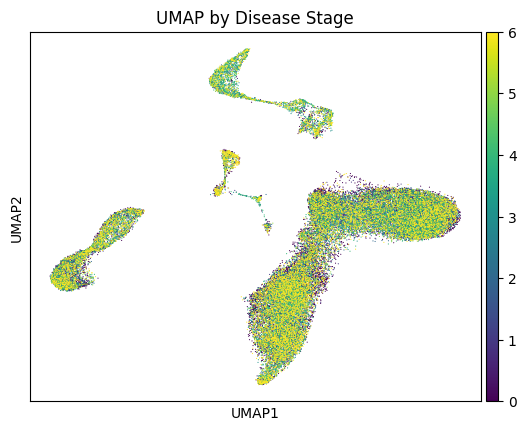

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

adata = sc.read_h5ad("nCoV_dataset.h5ad")

# Plot UMAP colored by patient group (Stage)
sc.pl.umap(adata, color="Stage", title="UMAP by Disease Stage", palette="Set2")


In [64]:
print(adata.X.shape)

(46022, 2000)


In [44]:
print(adata.obs.keys())

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt',
       'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage',
       'sample_name', 'condition', 'cell_type_name'],
      dtype='object')


In [40]:
# print(type(adata.obs))

print(adata.obs["batch"].value_counts())

batch
1     4749
2     4595
8     3874
6     3139
22    2877
5     2793
14    2753
15    2169
16    1960
3     1919
4     1678
11    1559
9     1519
19    1488
18    1464
0     1374
13    1307
20    1240
12     994
7      922
10     590
17     531
21     528
Name: count, dtype: int64


In [38]:
batch_to_condition = {
    0: "Ctrl-1",
    1: "Ctrl-2",
    2: "Ctrl-3",
    3: "Flu-1-D1",
    4: "Flu-1-D14",
    5: "Flu-2-D1",
    6: "Flu-2-D9",
    7: "COV-1-D1",
    8: "COV-1-D4",
    9: "COV-1-D16",
    10: "COV-2-D1",
    11: "COV-2-D4",
    12: "COV-2-D7",
    13: "COV-2-D10",
    14: "COV-2-D16",
    15: "COV-3-D1",
    16: "COV-3-D4",
    17: "COV-3-D16",
    18: "COV-4-D4",
    19: "COV-4-D16",
    20: "COV-5-D1",
    21: "COV-5-D7",
    22: "COV-5-D13",
}

# Add readable sample labels to adata.obs
adata.obs["sample_name"] = adata.obs["batch"].map(batch_to_condition)

# Then create higher-level condition labels from these
def categorize(sample):
    if sample.startswith("Ctrl"):
        return "Control"
    elif sample.startswith("COV"):
        return "COVID"
    elif sample.startswith("Flu") or sample.startswith("IAV"):
        return "IAV"
    else:
        return "Unknown"

adata.obs["condition"] = adata.obs["sample_name"].apply(categorize)

condition
COVID      25775
Control    10718
IAV         9529
Name: count, dtype: int64
sample_name
Ctrl-2       4749
Ctrl-3       4595
COV-1-D4     3874
Flu-2-D9     3139
COV-5-D13    2877
Flu-2-D1     2793
COV-2-D16    2753
COV-3-D1     2169
COV-3-D4     1960
Flu-1-D1     1919
Flu-1-D14    1678
COV-2-D4     1559
COV-1-D16    1519
COV-4-D16    1488
COV-4-D4     1464
Ctrl-1       1374
COV-2-D10    1307
COV-5-D1     1240
COV-2-D7      994
COV-1-D1      922
COV-2-D1      590
COV-3-D16     531
COV-5-D7      528
Name: count, dtype: int64


In [41]:
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

adata.obs["cell_type_name"] = adata.obs["cell_type"].map(cell_type_mapping)

cell_type_name
Naive T cells            13052
Cytotoxic CD8 T cells     6766
NKs                       5106
MAIT                      4507
Activated CD4 T cells     4376
Naive B cells             3311
Memory B cells            2601
Plasma                    2256
XCL+ NKs                  1325
Cycling T cells           1063
Monocytes                  644
DCs                        360
Cycling Plasma             339
Stem cells                 160
Megakaryocytes             156
Name: count, dtype: int64


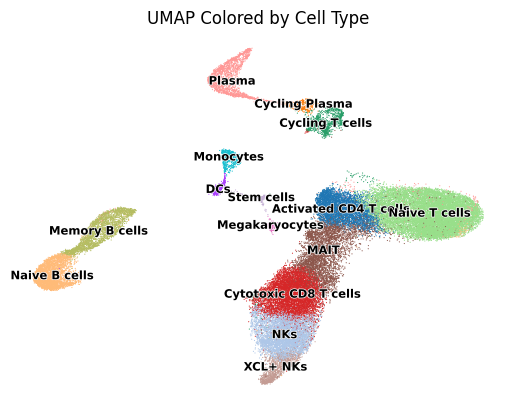

In [42]:
sc.pl.umap(
    adata,
    color="cell_type_name",
    legend_loc="on data",
    title="UMAP Colored by Cell Type",
    frameon=False,
    legend_fontsize="small",
    legend_fontoutline=1
)

In [43]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# List of genes in the same order as the figure
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R",
    "IL6ST", "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14",
    "STAT1", "IRF3", "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL",
    "RUNX3", "BCLAF1", "JUND", "NFKB1", "PHF3", "CD69", "IL4R"
]

# Order of sample names as shown in the figure
sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

# Filter adata to only include selected genes and samples
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order), :].copy()

# Extract raw expression matrix for the selected genes
X = adata_filtered.raw[:, genes].X.toarray() if hasattr(adata_filtered.raw[:, genes].X, "toarray") else adata_filtered.raw[:, genes].X
df = pd.DataFrame(X, columns=genes)
df["sample_name"] = adata_filtered.obs["sample_name"].values

# Average expression per sample
avg_expr = df.groupby("sample_name").mean().loc[sample_order].T

# Z-score normalization per gene
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(avg_expr.T).T, index=avg_expr.index, columns=avg_expr.columns)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(z_scores, cmap="RdBu_r", center=0, xticklabels=True, yticklabels=True, cbar_kws={"label": "Z-score"})
plt.xticks(rotation=90)
plt.title("Gene Expression Heatmap (Z-score normalized)")
plt.tight_layout()
plt.show()


KeyError: "Values [np.str_('CNBP'), np.str_('PFDN5'), np.str_('BTF3'), np.str_('SAP18'), np.str_('ZFP36'), np.str_('ZFP36L2'), np.str_('IL10RB'), np.str_('IL6R'), np.str_('IL6ST'), np.str_('IL27RA'), np.str_('IL17RA'), np.str_('IL2RA'), np.str_('IL10RA'), np.str_('IL7R'), np.str_('IFNAR1'), np.str_('TNFSF14'), np.str_('STAT1'), np.str_('IRF3'), np.str_('TNFSF10'), np.str_('TNF'), np.str_('IL23A'), np.str_('IFNG'), np.str_('STAT3'), np.str_('CHD1'), np.str_('REL'), np.str_('RUNX3'), np.str_('BCLAF1'), np.str_('JUND'), np.str_('NFKB1'), np.str_('PHF3'), np.str_('CD69'), np.str_('IL4R')], from [np.str_('CNBP'), np.str_('PFDN5'), np.str_('BTF3'), np.str_('SAP18'), np.str_('ZFP36'), np.str_('ZFP36L2'), np.str_('IL10RB'), np.str_('IL6R'), np.str_('IL6ST'), np.str_('IL27RA'), np.str_('IL17RA'), np.str_('IL2RA'), np.str_('IL10RA'), np.str_('IL7R'), np.str_('IFNAR1'), np.str_('TNFSF14'), np.str_('STAT1'), np.str_('IRF3'), np.str_('TNFSF10'), np.str_('TNF'), np.str_('IL23A'), np.str_('IFNG'), np.str_('STAT3'), np.str_('CHD1'), np.str_('REL'), np.str_('RUNX3'), np.str_('BCLAF1'), np.str_('JUND'), np.str_('NFKB1'), np.str_('PHF3'), np.str_('CD69'), np.str_('IL4R')], are not valid obs/ var names or indices."

In [61]:
target_genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

# Use .raw.var_names if available, otherwise fallback
gene_index = adata.raw.var["_index"].values  # Get the actual array of gene names
gene_index = [str(gene) for gene in gene_index]

print(sorted(gene_index))

found_genes = [g for g in target_genes if g in gene_index]
missing_genes = [g for g in target_genes if g not in gene_index]

print("✅ Found genes:", found_genes)
print("❌ Missing genes:", missing_genes)

['AAMDC', 'AARS', 'ABCB9', 'ABCC3', 'ABCC4', 'ABHD11', 'ABHD4', 'ABRACL', 'ABT1', 'AC078883.3', 'AC104024.1', 'AC233755.1', 'AC233755.2', 'ACAA2', 'ACADM', 'ACAT1', 'ACO1', 'ACO2', 'ACOT7', 'ACOT8', 'ACP1', 'ACRBP', 'ACTB', 'ACTG1', 'ADAL', 'ADAM12', 'ADAM19', 'ADAM23', 'ADAM28', 'ADAM9', 'ADAMTS1', 'ADGRE2', 'ADI1', 'ADK', 'ADPRH', 'ADRM1', 'AEBP1', 'AFAP1', 'AFF3', 'AGPAT2', 'AHCY', 'AHSA1', 'AIF1', 'AIFM1', 'AIFM2', 'AIM2', 'AIMP2', 'AK2', 'AKR1A1', 'AKR1C3', 'AKR7A2', 'AL928768.3', 'ALCAM', 'ALDH18A1', 'ALDH1L2', 'ALDH2', 'ALDOA', 'ALG1', 'ALG14', 'ALG2', 'ALG3', 'ALG5', 'ALKBH2', 'ALKBH3', 'ALKBH4', 'ALOX5', 'ALOX5AP', 'AMDHD2', 'ANAPC11', 'ANG', 'ANKRD18A', 'ANKRD26', 'ANKRD28', 'ANKRD31', 'ANLN', 'ANP32A', 'ANP32E', 'ANXA1', 'ANXA2', 'ANXA4', 'ANXA5', 'AP1S2', 'AP2S1', 'APOBEC3G', 'APP', 'AQP3', 'AREG', 'ARF1', 'ARF4', 'ARFGAP3', 'ARHGAP11A', 'ARHGAP11B', 'ARHGAP21', 'ARHGEF12', 'ARHGEF19', 'ARID3A', 'ARL3', 'ARL6IP1', 'ARMCX2', 'ARMCX3', 'ARNTL2', 'ARPC1B', 'ARPC2', 'ARPC5', 'A

In [74]:
print(adata.shape)

(46022, 2000)


In [50]:
print(adata.raw.var_names)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999'],
      dtype='object', length=2000)


In [49]:
print(adata.raw.var)

      _index
0      IGHA1
1     JCHAIN
2       IGKC
3      IGHG4
4      IGLC2
...      ...
1995   KLHL3
1996    COQ5
1997  CORO1C
1998  MB21D1
1999   CDAN1

[2000 rows x 1 columns]


In [10]:
print(adata.uns.get("cell_type_annotations"))

None


In [11]:
print(adata.uns.get("cell_type_colors"))

None


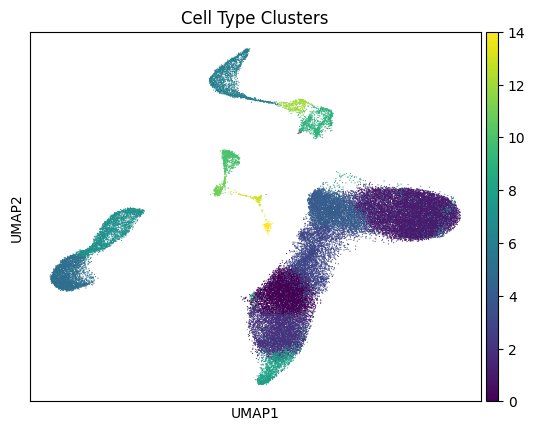

cell_type
0      6766
1     13052
2      5106
3      4507
4      4376
5      3311
6      2256
7      2601
8      1325
9      1063
10      644
11      360
12      339
13      160
14      156
Name: count, dtype: int64


In [23]:
# Quick UMAP with raw cluster labels
sc.pl.umap(adata, color="cell_type", legend_loc="on data", title="Cell Type Clusters")

# See the cluster counts
print(adata.obs["cell_type"].value_counts().sort_index())

In [18]:
print(adata.uns_keys())

[]


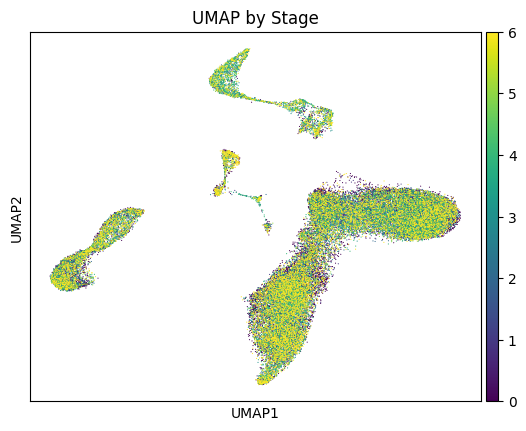

In [32]:
sc.pl.umap(adata, color="Stage", title="UMAP by Stage")

In [75]:
print(adata.raw.var.head())

   _index
0   IGHA1
1  JCHAIN
2    IGKC
3   IGHG4
4   IGLC2


In [76]:
adata.raw.var_names_make_unique()

AttributeError: 'Raw' object has no attribute 'var_names_make_unique'